# Solving Single Decisions

## The "Party Problem" example

JMA 11 Jan 2024

In [1]:
# Imports from the python standard library
import math, re, os, sys 
from pathlib import Path
import itertools            # to flatten lists

# Import array and dataframe packages
import numpy as np
# import numpy.linalg as la
import pandas as pd
import torch

import networkx as nx

# Use to parse xdsl files
# import xml.etree.ElementTree as et
# for extract_net
import BN

from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sn 
# Import the bokeh python wrappers for javascript plots
#  - a preferred visualization tool
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, VBar, Span
from bokeh.io import output_notebook
output_notebook()

NETWORK_FILE = 'PartyProblem_asym.xdsl' # 'PartyProblem_asym.xdsl'  # 

Loading BokehJS ...

In [2]:
# BN structure is contained under the node branch
parsed = BN.extract_net(NETWORK_FILE)
nodes, extensions = parsed
# tags tell the node type. 
[( k.get('id'), k.tag) for k in nodes]

found nodes


[('Party_location', 'decision'),
 ('Weather', 'cpt'),
 ('Preferences', 'utility'),
 ('Utility', 'maux'),
 ('Adjustor', 'cpt'),
 ('Detector', 'cpt')]

## Bayes networks object

It contains 

- the parse of the network as a dictionary with node names as keys
- The graph object showing network structure
- Potential objects for computation. 

CPT parent order: Dimensions are stored in matrix dimension order. 

In [3]:
# view the XML of an element
# CPT contents are stored in row major order (first row, second row, ...)
# Parents are the first matrix dimension -- matrix is Row Markov
# et.dump(
pp_net = BN.reap(parsed)
pp_net.pr_nodes()


>>> Party_location <<<
	kind: decision
	parents: []
	states: ['Outdoors', 'Porch', 'Indoors']
	position: [245, 268, 324, 324]

>>> Weather <<<
	kind: cpt
	parents: []
	states: ['Sunshine', 'Rain']
	potential:  ['Weather']
	 [0.4000, 0.6000]
	position: [298, 119, 408, 174]

>>> Preferences <<<
	kind: utility
	parents: ['Weather', 'Party_location']
	states: ['utility']
	potential:  ['Preferences', 'Weather', 'Party_location']
	 [[[100.,  90.,  40.],
         [  0.,  20.,  50.]]]
	position: [435, 281, 573, 329]

>>> Utility <<<
	kind: maux
	parents: ['Preferences']
	position: [660, 279, 746, 327]

>>> Adjustor <<<
	kind: cpt
	parents: []
	states: ['absent', 'ppresent']
	potential:  ['Adjustor']
	 [0.1000, 0.9000]
	position: [62, 81, 174, 116]

>>> Detector <<<
	kind: cpt
	parents: ['Weather', 'Adjustor']
	states: ['SaySun', 'SayRain']
	potential:  ['Detector', 'Weather', 'Adjustor']
	 [[[0.5100, 0.4900],
         [0.8700, 0.1300]],

        [[0.4800, 0.5200],
         [0.4000, 0.6000]]]
	

### Include state and variable names to tensor dimensions

### Add graph structure

In [4]:
pp_net.pr_influences()



Node	{ancestors}
	{descendants}

Weather :  set() 
	 {'Utility', 'Detector', 'Preferences'} 

Preferences :  {'Weather', 'Party_location'} 
	 {'Utility'} 

Party_location :  set() 
	 {'Utility', 'Preferences'} 

Utility :  {'Weather', 'Party_location', 'Preferences'} 
	 set() 

Detector :  {'Adjustor', 'Weather'} 
	 set() 

Adjustor :  set() 
	 {'Detector'} 



In [5]:
pp_net.pr_named_tensors()

Weather 
	 OrderedDict({'Weather': 2})
	tensor([0.4000, 0.6000]) 

Preferences 
	 OrderedDict({'Preferences': 1, 'Weather': 2, 'Party_location': 3})
	tensor([[[100.,  90.,  40.],
         [  0.,  20.,  50.]]]) 

Adjustor 
	 OrderedDict({'Adjustor': 2})
	tensor([0.1000, 0.9000]) 

Detector 
	 OrderedDict({'Detector': 2, 'Weather': 2, 'Adjustor': 2})
	tensor([[[0.5100, 0.4900],
         [0.8700, 0.1300]],

        [[0.4800, 0.5200],
         [0.4000, 0.6000]]]) 



In [11]:
pp_net

In [10]:
def pr_network(bn):
    positions = bn.center_dict
    DG = bn.network
    plt.figure(figsize=(6,3))
    nx.draw_networkx_labels(DG, pos=positions)
    nx.draw_networkx_nodes(DG, pos=positions, node_color='lightgrey')
    nx.draw_networkx_edges(DG, pos=positions)

pr_network(pp_net)

AttributeError: 'BN' object has no attribute 'center_dict'

### Extract matrices as tensors.  _List all tensors_

In [ ]:
# See p. 270, Howard & Abbas
# P( detector | weather)

def pr_node_tensor(the_n):
    print(a_node, '\n\t', get_potential(the_n, bn.n_dict),'\n')


def pr_named_tensors(name_dict = bn.n_dict):
    'Show all the model tensors'
    for a_node in name_dict:
        if name_dict[a_node]['kind'] == 'cpt' or name_dict[a_node]['kind'] == 'utility':
            print(a_node, '\n\t', get_potential(a_node, bn.n_dict),'\n')

pr_named_tensors(bn.n_dict)

Weather 
	 OrderedDict({'Weather': 2})
	tensor([0.4000, 0.6000]) 

Preferences 
	 OrderedDict({'Preferences': 1, 'Weather': 2, 'Party_location': 3})
	tensor([[[100.,  90.,  40.],
         [  0.,  20.,  50.]]]) 

Adjustor 
	 OrderedDict({'Adjustor': 2})
	tensor([0.1000, 0.9000]) 

Detector 
	 OrderedDict({'Detector': 2, 'Weather': 2, 'Adjustor': 2})
	tensor([[[0.5100, 0.4900],
         [0.8700, 0.1300]],

        [[0.4800, 0.5200],
         [0.4000, 0.6000]]]) 



In [ ]:
# Format one-dim tensors 
# from collections import deque
def one_dim_table(the_potential, the_var, n_dict=bn.n_dict, **args):
    def que_copy(prefix, queue):
       if not isinstance(queue, list):
           queue = [queue]
       queue.insert(0, prefix)
       return queue
    states = n_dict[the_var]['states']
    values = the_potential.tolist()
    # Flatten nested lists
    while len(values)  == 1:   # TODO is this test necessary?
        values = values[0]
    print(f' *** {the_var} ***')
    values = [que_copy(s, v) for s, v in zip(states, values)]
    print(tabulate(values, **args))

one_dim_table(get_potential('Weather', bn.n_dict).p, 'Weather', tablefmt= '.4f', headers= ['State', 'Value'])
# get_potential('Weather', bn.n_dict).p.tolist()


 *** Weather ***
State       Value
--------  -------
Sunshine      0.4
Rain          0.6


In [ ]:
## For joining by aligning potentials as named tensors

def dim_index(potential_cpt, candidate):
    # Starting with 0 as the first location, so the last location equals the length of the shape
    cpt_dims = potential_cpt.dim_names
    # if its included is it not already last?
    if candidate in cpt_dims and candidate != list(cpt_dims)[-1]:
        return list(cpt_dims).index(candidate) 
    else:
        # Either candidate not found or its already at the end, so do nothing.
        return None

def move_named_dim_to_end(the_named_tensor, the_dimension):
    'Transpose the potential place the dimension last'
    the_dim_index = dim_index(the_named_tensor, the_dimension)
    if the_dim_index is not None:
        # Create a modified shape OrderedDict
        shape = the_named_tensor.shape.copy()
        shape.move_to_end(the_dimension)
        # Rotate the tensor dimensions
        p_transpose = list(range(len(shape)))               # The unperturbed list
        p_transpose.append(p_transpose.pop(the_dim_index))  # Move index to end
        # Transpose CPT
        x = the_named_tensor.p.permute(p_transpose)
        return Potential(x, shape)
    else:
        # A no op
        return the_named_tensor 
    
def marginalize_last(p1, p2):
    '''For a potential matching the last dimension of the other, join them,
    then marginalized out the last dimension'''
    if list(p1.shape)[-1] != list(p2.shape)[-1]:           # Compare shapes by indexed value
        print(f'Err, last shapes do not match:\t{list(p1.shape)[-1]} != {list(p2.shape)[-1]}')
        return None
    else:
        new_tensor = (p1.p * p2.p).sum(-1)
        # The symmetric set difference - those not common to both. 
        s1 = set(p1.shape.items())
        s2 = set(p2.shape.items())
        new_shape = OrderedDict(s1.union(s2) - s1.intersection(s2))
    return Potential(new_tensor, new_shape)

### Utilities

In [ ]:
# Utility matrix, as a Potential
outcome_potential = get_potential('Preferences', bn.n_dict)
outcome_potential

OrderedDict({'Preferences': 1, 'Weather': 2, 'Party_location': 3})
	tensor([[[100.,  90.,  40.],
         [  0.,  20.,  50.]]])

In [ ]:
# No problem with mapping single arg functions over tensors!  
def delta_utility(x, exponand = 0.5, normalize = 50):
    dims = x.shape
    u = 4/3*(1 - pow(exponand, (x.p/normalize)))
    return Potential(u, dims)

u = delta_utility(outcome_potential)
u

OrderedDict({'Preferences': 1, 'Weather': 2, 'Party_location': 3})
	tensor([[[1.0000, 0.9504, 0.5675],
         [0.0000, 0.3229, 0.6667]]])

## Solving the party problem

To determine the optimal policy

* join Detector and Weather CPTs 
* join DW with Utility (Decision is implicit in Utility, w/ unit values for all options)
* marginalize out unobserved Weather (or do this after decn, to get VOI)
* Maximize over options

### First solution - only prior, no observation 

In [ ]:
# Note that marginalize_last is symmetric in its arguments. 

preference_transpose = move_named_dim_to_end(get_potential("Preferences", bn.n_dict), "Weather")
preference_transpose


OrderedDict({'Preferences': 1, 'Party_location': 3, 'Weather': 2})
	tensor([[[100.,   0.],
         [ 90.,  20.],
         [ 40.,  50.]]])

In [ ]:
prior_utility = marginalize_last(preference_transpose, get_potential("Weather",bn.n_dict))
one_dim_table(prior_utility.p, 'Party_location') 

 *** Party_location ***
--------  --
Outdoors  40
Porch     48
Indoors   46
--------  --


In [ ]:
# pre_posterior, shape =  weather_cpt.p @ detector_cpt.p.permute(2,0,1) @ adjustor_cpt.p
# pre_posterior

def marginalize(child_potential, parent_potential):
    cpt = (child_potential.p * parent_potential.p).sum(-1)
    # TODO remove parent shape from child
    sh = OrderedDict(set(child_potential.shape.items()) - set(parent_potential.shape.items()))
    return Potential(cpt, sh)

def shift_to_end(the_shape, the_var):
    the_shape.move_to_end(the_var)
    return the_shape


def join_parent(the_conditional, the_parent, name_dict= bn.n_dict):
    'Assume the parent rv is the last dim in the conditional, and marginalize out that dim'
    # Find the parent and transpose it to last dim
    c_potential = get_potential(the_conditional, name_dict)
    p_potential = get_potential(the_parent, name_dict)
    found_dim = dim_index(c_potential,the_parent)
    # Is found dim not already in the last dim? 
    new_shape = c_potential.shape
    if found_dim is not None:   # TODO does this work if the found dim is first?
        # Move found_dim to last dimension
        new_shape = shift_to_end(new_shape, the_parent)
        c_transpose = list(range(len(new_shape)))
        c_transpose.append(c_transpose.pop(found_dim))
        # Transpose CPT
        c_potential.p.permute(c_transpose)
        # TODO - create a new potential? 
    new_joint =  Potential(c_potential.p * p_potential.p, new_shape)
    return new_joint

    # return the joint potential, with the conditioning prob last. 
# join_parent(marginalize_parent(detector_cpt.permute(2,1,0), adjustor_cpt), weather_cpt)
dw_joint = join_parent("Detector", 'Weather')
dw_joint


OrderedDict({'Detector': 2, 'Adjustor': 2, 'Weather': 2})
	tensor([[[0.2040, 0.2940],
         [0.3480, 0.0780]],

        [[0.1920, 0.3120],
         [0.1600, 0.3600]]])

In [ ]:
# P( Weather | Detector) - column markov
# See p 270 Figure 13.6
#   Transpose the joint to get the Detector in last dim, and normalize 
pre_posterior_p = dw_joint.p.sum(-1) 
p = dw_joint.p.transpose(0,1) * (1/pre_posterior_p)
# reverse the shape 
posterior = Potential(p, OrderedDict(list(reversed(dw_joint.shape.items()))) )
print(pre_posterior_p, '\n\n', posterior)



tensor([[0.4980, 0.4260],
        [0.5040, 0.5200]]) 

 OrderedDict({'Weather': 2, 'Adjustor': 2, 'Detector': 2})
	tensor([[[0.4096, 0.6901],
         [0.3810, 0.6000]],

        [[0.6988, 0.1831],
         [0.3175, 0.6923]]])


In [ ]:
extended_preference * posterior.p

tensor([[[[[40.9639, 69.0141],
           [38.0952, 60.0000]],

          [[ 0.0000,  0.0000],
           [ 0.0000,  0.0000]]],


         [[[36.8675, 62.1127],
           [34.2857, 54.0000]],

          [[13.9759,  3.6620],
           [ 6.3492, 13.8462]]],


         [[[16.3855, 27.6056],
           [15.2381, 24.0000]],

          [[34.9398,  9.1549],
           [15.8730, 34.6154]]]]])

In [ ]:
# One approach is to add a unsqueeze dim to match Detector at the end of preference transpose
# BINGO
extended_preference = preference_transpose.p.unsqueeze(-1).unsqueeze(-1)
print(extended_preference.shape)
# Sum out the weather dimension
policy_values = (extended_preference * posterior.p).sum(2)
print('E[ V | Party_location, Detector] = ')
policy_values
# Next we need to weight the optimal in each column by the pre-posterior.

torch.Size([1, 3, 2, 1, 1])
E[ V | Party_location, Detector] = 


tensor([[[[40.9639, 69.0141],
          [38.0952, 60.0000]],

         [[50.8434, 65.7746],
          [40.6349, 67.8461]],

         [[51.3253, 36.7606],
          [31.1111, 58.6154]]]])

In [ ]:
# TODO Need to format list entries before passing to tabulate. 
# TODO looks like the State labels are flipped. 
detector_states= bn.n_dict['Detector']['states'].copy()
detector_states.insert(0, 'State')
one_dim_table(policy_values.squeeze(0), 
    'Party_location', 
    floatfmt= ".3f", 
    headers= detector_states)
        

 *** Party_location ***
State     SaySun                                  SayRain
--------  --------------------------------------  ----------------------------------------
Outdoors  [40.96385192871094, 69.01408386230469]  [38.095237731933594, 59.999996185302734]
Porch     [50.84336853027344, 65.77464294433594]  [40.634918212890625, 67.84614562988281]
Indoors   [51.32529830932617, 36.76055908203125]  [31.11111068725586, 58.615379333496094]


In [ ]:
policy_values.squeeze(0).sum(-1)

tensor([[109.9779,  98.0952],
        [116.6180, 108.4811],
        [ 88.0859,  89.7265]])

<Axes: >

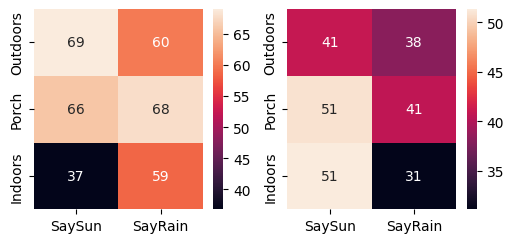

In [ ]:
# TODO what is the last dim?  Need to remove it. 
fig, ax = plt.subplots(1,2, figsize = (6, 2.6))
policy_values_2d_a = pd.DataFrame(policy_values.squeeze(0)[:,:,1], columns = bn.n_dict['Detector']['states'], 
                                index = bn.n_dict['Party_location']['states'])
sn.heatmap(policy_values_2d_a, annot=True, xticklabels=True, yticklabels=True, ax=ax[0])
policy_values_2d_b = pd.DataFrame(policy_values.squeeze(0)[:,:,0], columns = bn.n_dict['Detector']['states'], 
                                index = bn.n_dict['Party_location']['states'])
sn.heatmap(policy_values_2d_b, annot=True, xticklabels=True, yticklabels=True, ax=ax[1])

In [ ]:
# Find the max value in each column. 
decn = policy_values.max(1)
decn.values, decn.indices

(tensor([[[51.3253, 69.0141],
          [40.6349, 67.8461]]]),
 tensor([[[2, 0],
          [1, 1]]]))

In [ ]:
# Value with information. 
# However utility should be applied after computing expected values to get certain equivalents
# sigh
# 0.7782 * 0.44 + 0.6557 * 0.56
decn.values @ get_potential('Weather', bn.n_dict).p

tensor([[61.9386, 56.9617]])